<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import (
    RepeatVector,
    Conv2D,
    SimpleRNN,
    GRU,
    Reshape,
    ConvLSTM2D,
    Conv2DTranspose,
)

2023-12-03 15:06:18.469259: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


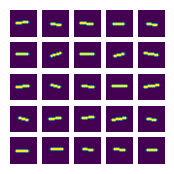

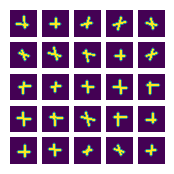

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign="-"):
    blank_images = np.zeros(
        [number_of_images, 28, 28]
    )  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2))  # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)  # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)  # -||-

    for i in range(number_of_images):  # Generate n different images
        cv2.line(
            blank_images[i],
            (y1[i], x[i, 0]),
            (y2[i], x[i, 1]),
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )  # Draw lines with randomized coordinates
        if sign == "+":
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )  # Draw lines with randomized coordinates
        if sign == "*":
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i + 1)
        plt.axis("off")
        plt.imshow(images[i])
    plt.show()


show_generated(generate_images())
show_generated(generate_images(sign="+"))

In [3]:
def create_data(highest_integer, num_addends=2, operands=["+", "-"]):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels == x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping["-"] = generate_images()
    image_mapping["+"] = generate_images(sign="+")
    image_mapping["*"] = generate_images(sign="*")
    image_mapping[" "] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):  # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands:  # Create all possible combinations of operands
                query_string = to_padded_chars(
                    str(i) + sign + str(j), max_len=max_query_length, pad_right=True
                )
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(
                    result, max_len=max_answer_length, pad_right=True
                )
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return (
        np.stack(X_text),
        np.stack(X_img) / 255.0,
        np.stack(y_text),
        np.stack(y_img) / 255.0,
    )


def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * " "
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #3126

X_text: "15+63" = y_text: "78 "


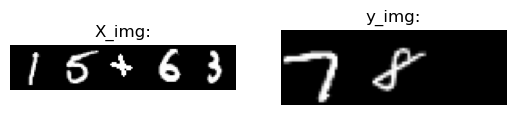

Query #6391

X_text: "31-95" = y_text: "-64"


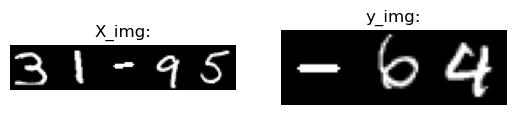

Query #1598

X_text: "7+99 " = y_text: "106"


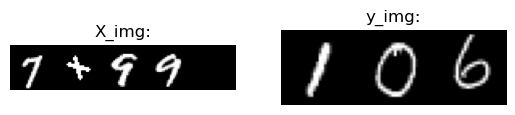

Query #2481

X_text: "12-40" = y_text: "-28"


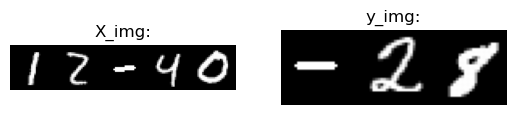

Query #4972

X_text: "24+86" = y_text: "110"


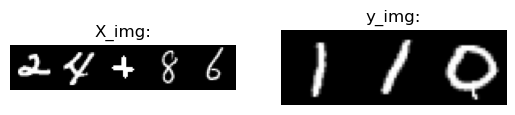

Query #3428

X_text: "17+14" = y_text: "31 "


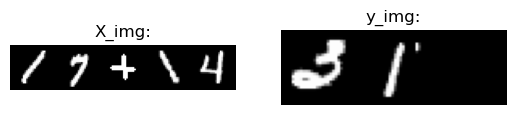

Query #6731

X_text: "33-65" = y_text: "-32"


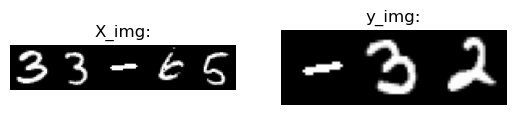

Query #6196

X_text: "30+98" = y_text: "128"


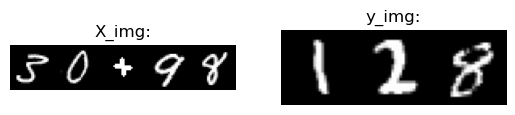

Query #7075

X_text: "35-37" = y_text: "-2 "


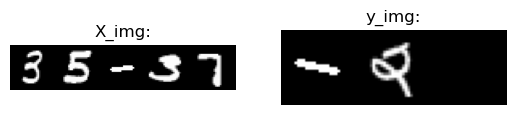

Query #6177

X_text: "30-88" = y_text: "-58"


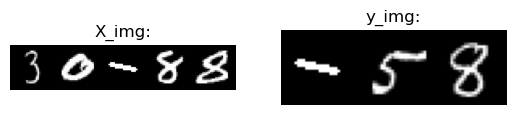

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = "0123456789+- "  # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99  # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = (
    max_int_length * 2 + 1
)  # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3  # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ["X_img:", "y_img:"]
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1, 2, i + 1)
        # plt.set_figheight(15)
        plt.axis("off")
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap="gray")
    print("=" * 50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()


for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks


def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = "".join([unique_characters[i] for i in pred])

    return predicted


X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    text2text.summary()

    return text2text


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [11]:
## Your code


def build_image_to_text_model():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text


# add one additional LSTM to the model
def build_image_to_text_model_v2():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text


# add one additional LSTM to the model
def build_image_to_text_model_v3():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text

In [8]:
def train_and_evaluate(split_ratio, X_data, y_data, model):
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=split_ratio, random_state=42
    )

    # Training the model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    # Predicting and comparing with true labels
    predictions = model.predict(X_test)

    true_labels = []
    predicted_labels = []

    for i in range(len(X_test)):
        true_label = decode_labels(y_test[i])
        predicted_label = decode_labels(predictions[i])

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # Return the accuracy and the labels for visualization
    return accuracy, true_labels, predicted_labels


# Modified training and evaluation for different splits
splits = [0.5, 0.75, 0.9]  # Train-test splits, the number is the ratio of test data
results_p1_2_v1 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model()
    )
    results_p1_2_v1[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-03 15:06:48.322183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:06:48.323977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:06:48.325405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 784)           0         
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 384)               1795584   
                                                                 
 repeat_vector (RepeatVector  (None, 3, 384)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                        

2023-12-03 15:06:48.652542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:06:48.653985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:06:48.656080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:06:49.587702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:06:49.589281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:06:49.590537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 1.9288 - accuracy: 0.3657

2023-12-03 15:07:15.524238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:07:15.526122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:07:15.527837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 32s 89ms/step - loss: 1.9288 - accuracy: 0.3657 - val_loss: 1.7275 - val_accuracy: 0.4002
Epoch 2/20
313/313 [==============================] - 27s 86ms/step - loss: 1.6498 - accuracy: 0.4218 - val_loss: 1.5982 - val_accuracy: 0.4350
Epoch 3/20
313/313 [==============================] - 28s 89ms/step - loss: 1.5234 - accuracy: 0.4532 - val_loss: 1.5437 - val_accuracy: 0.4494
Epoch 4/20
313/313 [==============================] - 28s 89ms/step - loss: 1.4240 - accuracy: 0.4848 - val_loss: 1.5063 - val_accuracy: 0.4570
Epoch 5/20
313/313 [==============================] - 33s 105ms/step - loss: 1.3293 - accuracy: 0.5096 - val_loss: 1.4804 - val_accuracy: 0.4683
Epoch 6/20
313/313 [==============================] - 28s 91ms/step - loss: 1.2414 - accuracy: 0.5398 - val_loss: 1.4806 - val_accuracy: 0.4766
Epoch 7/20
313/313 [==============================] - 28s 89ms/step - loss: 1.1564 - accuracy: 0.5700 - val_loss: 1.5191 - val_accuracy: 0.4780
Ep

2023-12-03 15:16:22.911881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:16:22.913660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:16:22.915431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 7s 19ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-03 15:16:30.329273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:16:30.330909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:16:30.332827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 384)               1795584   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                      

2023-12-03 15:16:30.724446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:16:30.726183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:16:30.727828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:16:31.854118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:16:31.857681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:16:31.861984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

156/157 [============================>.] - ETA: 0s - loss: 2.0465 - accuracy: 0.3454

2023-12-03 15:16:47.697585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:16:47.699100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:16:47.700522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 25s 125ms/step - loss: 2.0462 - accuracy: 0.3455 - val_loss: 1.8939 - val_accuracy: 0.3913
Epoch 2/20
157/157 [==============================] - 19s 118ms/step - loss: 1.8135 - accuracy: 0.3913 - val_loss: 1.7923 - val_accuracy: 0.3912
Epoch 3/20
157/157 [==============================] - 21s 133ms/step - loss: 1.6711 - accuracy: 0.4137 - val_loss: 1.6861 - val_accuracy: 0.4171
Epoch 4/20
157/157 [==============================] - 22s 141ms/step - loss: 1.5808 - accuracy: 0.4423 - val_loss: 1.6242 - val_accuracy: 0.4213
Epoch 5/20
157/157 [==============================] - 19s 124ms/step - loss: 1.4933 - accuracy: 0.4629 - val_loss: 1.6124 - val_accuracy: 0.4289
Epoch 6/20
157/157 [==============================] - 19s 123ms/step - loss: 1.4050 - accuracy: 0.4920 - val_loss: 1.5945 - val_accuracy: 0.4374
Epoch 7/20
157/157 [==============================] - 18s 117ms/step - loss: 1.3023 - accuracy: 0.5251 - val_loss: 1.6426 - val_accuracy: 0.4

2023-12-03 15:23:08.415972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:23:08.418129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:23:08.420256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 9s 17ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-03 15:23:17.758686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:23:17.760711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:23:17.762274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 384)               1795584   
                                                                 
 repeat_vector_2 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                      

2023-12-03 15:23:18.127630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:23:18.129302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:23:18.130934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:23:19.552861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:23:19.555355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:23:19.557186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

62/63 [============================>.] - ETA: 0s - loss: 2.1787 - accuracy: 0.2890

2023-12-03 15:23:28.242504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:23:28.244520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:23:28.245908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 19s 232ms/step - loss: 2.1776 - accuracy: 0.2895 - val_loss: 2.0464 - val_accuracy: 0.3486
Epoch 2/20
63/63 [==============================] - 13s 203ms/step - loss: 2.0005 - accuracy: 0.3577 - val_loss: 1.9470 - val_accuracy: 0.3790
Epoch 3/20
63/63 [==============================] - 14s 221ms/step - loss: 1.8704 - accuracy: 0.3945 - val_loss: 1.8522 - val_accuracy: 0.3919
Epoch 4/20
63/63 [==============================] - 13s 213ms/step - loss: 1.7692 - accuracy: 0.4048 - val_loss: 1.8138 - val_accuracy: 0.3901
Epoch 5/20
63/63 [==============================] - 15s 236ms/step - loss: 1.6729 - accuracy: 0.4193 - val_loss: 1.8114 - val_accuracy: 0.3880
Epoch 6/20
63/63 [==============================] - 14s 222ms/step - loss: 1.5757 - accuracy: 0.4425 - val_loss: 1.9057 - val_accuracy: 0.3746
Epoch 7/20
63/63 [==============================] - 14s 223ms/step - loss: 1.4865 - accuracy: 0.4753 - val_loss: 1.8952 - val_accuracy: 0.3818
Epoch 8/20

2023-12-03 15:28:27.325408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:28:27.327512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:28:27.329168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 11s 17ms/step


In [9]:
# the out put from model with two LSTM layers in encoder
results_p1_2_v2 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model_v2()
    )
    results_p1_2_v2[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-03 15:28:38.413489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:28:38.415553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:28:38.417341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_6 (LSTM)               (None, 5, 384)            1795584   
                                                                 
 lstm_7 (LSTM)               (None, 384)               1181184   
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_7 (TimeDis  (None, 3, 13)           

2023-12-03 15:28:39.175402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:28:39.177531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:28:39.179334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:28:40.161208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:28:40.163545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:28:40.165330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 1.9202 - accuracy: 0.3695

2023-12-03 15:29:22.739683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:29:22.743077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:29:22.745289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 54s 155ms/step - loss: 1.9202 - accuracy: 0.3695 - val_loss: 1.7025 - val_accuracy: 0.4115
Epoch 2/20
313/313 [==============================] - 42s 133ms/step - loss: 1.6267 - accuracy: 0.4268 - val_loss: 1.5984 - val_accuracy: 0.4327
Epoch 3/20
313/313 [==============================] - 38s 121ms/step - loss: 1.4943 - accuracy: 0.4609 - val_loss: 1.4707 - val_accuracy: 0.4678
Epoch 4/20
313/313 [==============================] - 41s 131ms/step - loss: 1.3923 - accuracy: 0.4947 - val_loss: 1.4188 - val_accuracy: 0.4831
Epoch 5/20
313/313 [==============================] - 51s 162ms/step - loss: 1.2926 - accuracy: 0.5245 - val_loss: 1.3691 - val_accuracy: 0.5097
Epoch 6/20
313/313 [==============================] - 48s 152ms/step - loss: 1.1947 - accuracy: 0.5607 - val_loss: 1.3485 - val_accuracy: 0.5197
Epoch 7/20
313/313 [==============================] - 40s 127ms/step - loss: 1.1142 - accuracy: 0.5849 - val_loss: 1.3320 - val_accuracy: 0.5

2023-12-03 15:42:52.097912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:42:52.100132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:42:52.102883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 11s 28ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-03 15:43:03.128332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:43:03.130758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:43:03.132866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_9 (LSTM)               (None, 5, 384)            1795584   
                                                                 
 lstm_10 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_4 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 3, 384)            1181184   
                                                                 
 time_distributed_9 (TimeDis  (None, 3, 13)           

2023-12-03 15:43:04.064833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:43:04.067257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:43:04.068918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:43:06.285460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:43:06.287824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:43:06.289716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 2.0561 - accuracy: 0.3420

2023-12-03 15:43:27.144862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:43:27.146307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:43:27.147760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 32s 159ms/step - loss: 2.0561 - accuracy: 0.3420 - val_loss: 1.8829 - val_accuracy: 0.3894
Epoch 2/20
157/157 [==============================] - 25s 159ms/step - loss: 1.7952 - accuracy: 0.3943 - val_loss: 1.7477 - val_accuracy: 0.3982
Epoch 3/20
157/157 [==============================] - 25s 161ms/step - loss: 1.6566 - accuracy: 0.4177 - val_loss: 1.6863 - val_accuracy: 0.4092
Epoch 4/20
157/157 [==============================] - 24s 154ms/step - loss: 1.5671 - accuracy: 0.4377 - val_loss: 1.5792 - val_accuracy: 0.4425
Epoch 5/20
157/157 [==============================] - 24s 152ms/step - loss: 1.4716 - accuracy: 0.4621 - val_loss: 1.5247 - val_accuracy: 0.4522
Epoch 6/20
157/157 [==============================] - 24s 151ms/step - loss: 1.3830 - accuracy: 0.4892 - val_loss: 1.5137 - val_accuracy: 0.4625
Epoch 7/20
157/157 [==============================] - 26s 164ms/step - loss: 1.2992 - accuracy: 0.5152 - val_loss: 1.5780 - val_accuracy: 0.4

2023-12-03 15:52:17.934697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:52:17.936936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:52:17.938686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 13s 24ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-03 15:52:31.033828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:52:31.035815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:52:31.037457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_13 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 3, 384)            1181184   
                                                                 
 time_distributed_11 (TimeDi  (None, 3, 13)           

2023-12-03 15:52:31.815797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:52:31.817619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:52:31.819458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 15:52:32.718957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:52:32.721340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:52:32.723264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 2.1785 - accuracy: 0.3008

2023-12-03 15:52:46.013464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 15:52:46.015116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 15:52:46.016629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 26s 301ms/step - loss: 2.1785 - accuracy: 0.3008 - val_loss: 2.0507 - val_accuracy: 0.3156
Epoch 2/20
63/63 [==============================] - 18s 295ms/step - loss: 2.0110 - accuracy: 0.3568 - val_loss: 1.9221 - val_accuracy: 0.3910
Epoch 3/20
63/63 [==============================] - 20s 314ms/step - loss: 1.8614 - accuracy: 0.3908 - val_loss: 1.8435 - val_accuracy: 0.3901
Epoch 4/20
63/63 [==============================] - 21s 331ms/step - loss: 1.7585 - accuracy: 0.3970 - val_loss: 1.7842 - val_accuracy: 0.3974
Epoch 5/20
63/63 [==============================] - 19s 309ms/step - loss: 1.6786 - accuracy: 0.4143 - val_loss: 1.8564 - val_accuracy: 0.3788
Epoch 6/20
63/63 [==============================] - 19s 307ms/step - loss: 1.6195 - accuracy: 0.4277 - val_loss: 1.7717 - val_accuracy: 0.3926
Epoch 7/20
63/63 [==============================] - 23s 367ms/step - loss: 1.5375 - accuracy: 0.4452 - val_loss: 1.7725 - val_accuracy: 0.3950
Epoch 8/20

2023-12-03 16:00:00.180295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:00:00.183440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:00:00.186199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 18s 28ms/step


In [12]:
# the out put from model with two LSTM layers in encoder
results_p1_2_v3 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model_v3()
    )
    results_p1_2_v3[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-03 16:40:54.082938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:40:54.084574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:40:54.085871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_18 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_19 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_20 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_6 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_21 (LSTM)              (None, 3, 384)           

2023-12-03 16:40:55.076584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:40:55.080510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:40:55.082106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 16:40:57.541227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:40:57.544738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:40:57.546886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 2.0363 - accuracy: 0.3387

2023-12-03 16:41:50.053240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:41:50.054769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:41:50.056634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 64s 177ms/step - loss: 2.0363 - accuracy: 0.3387 - val_loss: 1.8242 - val_accuracy: 0.3917
Epoch 2/20
313/313 [==============================] - 49s 157ms/step - loss: 1.6900 - accuracy: 0.4117 - val_loss: 1.5881 - val_accuracy: 0.4368
Epoch 3/20
313/313 [==============================] - 49s 157ms/step - loss: 1.5295 - accuracy: 0.4536 - val_loss: 1.5126 - val_accuracy: 0.4591
Epoch 4/20
313/313 [==============================] - 49s 156ms/step - loss: 1.4191 - accuracy: 0.4890 - val_loss: 1.4001 - val_accuracy: 0.4953
Epoch 5/20
313/313 [==============================] - 49s 157ms/step - loss: 1.3056 - accuracy: 0.5251 - val_loss: 1.3532 - val_accuracy: 0.5139
Epoch 6/20
313/313 [==============================] - 49s 156ms/step - loss: 1.2115 - accuracy: 0.5540 - val_loss: 1.2898 - val_accuracy: 0.5397
Epoch 7/20
313/313 [==============================] - 49s 158ms/step - loss: 1.1393 - accuracy: 0.5771 - val_loss: 1.2862 - val_accuracy: 0.5

2023-12-03 16:58:11.257732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:58:11.259921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:58:11.261649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 12s 31ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-03 16:58:23.090311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:58:23.091945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:58:23.093714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_22 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_23 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_24 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_7 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_25 (LSTM)              (None, 3, 384)           

2023-12-03 16:58:25.117502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:58:25.119024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:58:25.120762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 16:58:25.948250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:58:25.950177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:58:25.951565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 2.1130 - accuracy: 0.3131

2023-12-03 16:58:53.302609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 16:58:53.303993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 16:58:53.305258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 42s 223ms/step - loss: 2.1130 - accuracy: 0.3131 - val_loss: 2.0627 - val_accuracy: 0.3295
Epoch 2/20
157/157 [==============================] - 33s 213ms/step - loss: 1.8876 - accuracy: 0.3792 - val_loss: 1.7422 - val_accuracy: 0.4103
Epoch 3/20
157/157 [==============================] - 34s 219ms/step - loss: 1.7105 - accuracy: 0.4035 - val_loss: 1.6414 - val_accuracy: 0.4142
Epoch 4/20
157/157 [==============================] - 34s 219ms/step - loss: 1.6074 - accuracy: 0.4287 - val_loss: 1.5856 - val_accuracy: 0.4373
Epoch 5/20
157/157 [==============================] - 34s 220ms/step - loss: 1.5252 - accuracy: 0.4471 - val_loss: 1.5361 - val_accuracy: 0.4495
Epoch 6/20
157/157 [==============================] - 34s 217ms/step - loss: 1.4535 - accuracy: 0.4734 - val_loss: 1.5363 - val_accuracy: 0.4556
Epoch 7/20
157/157 [==============================] - 34s 217ms/step - loss: 1.3666 - accuracy: 0.4958 - val_loss: 1.4957 - val_accuracy: 0.4

2023-12-03 17:10:18.154743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:10:18.156763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:10:18.158505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 16s 31ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-03 17:10:34.733092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:10:34.734963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:10:34.736400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_26 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_27 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_28 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_8 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_29 (LSTM)              (None, 3, 384)           

2023-12-03 17:10:36.356231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:10:36.357702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:10:36.359304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-03 17:10:37.152394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:10:37.154457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:10:37.155980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 2.1859 - accuracy: 0.3057

2023-12-03 17:10:52.189192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:10:52.190751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:10:52.192035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 32s 400ms/step - loss: 2.1859 - accuracy: 0.3057 - val_loss: 2.0740 - val_accuracy: 0.3039
Epoch 2/20
63/63 [==============================] - 25s 400ms/step - loss: 2.0681 - accuracy: 0.3188 - val_loss: 2.0569 - val_accuracy: 0.3256
Epoch 3/20
63/63 [==============================] - 25s 408ms/step - loss: 2.0363 - accuracy: 0.3425 - val_loss: 1.9545 - val_accuracy: 0.3873
Epoch 4/20
63/63 [==============================] - 26s 421ms/step - loss: 1.9030 - accuracy: 0.3912 - val_loss: 1.8420 - val_accuracy: 0.3892
Epoch 5/20
63/63 [==============================] - 30s 488ms/step - loss: 1.7773 - accuracy: 0.3910 - val_loss: 1.7755 - val_accuracy: 0.3918
Epoch 6/20
63/63 [==============================] - 29s 469ms/step - loss: 1.6980 - accuracy: 0.4087 - val_loss: 1.7438 - val_accuracy: 0.4033
Epoch 7/20
63/63 [==============================] - 27s 435ms/step - loss: 1.6215 - accuracy: 0.4243 - val_loss: 1.7035 - val_accuracy: 0.4052
Epoch 8/20

2023-12-03 17:22:03.655012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 17:22:03.660643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 17:22:03.664891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 39s 63ms/step


In [13]:
# convert the labels to int for better visualization and comparison
def convert_to_int(results):
    def string_to_float(s):
        try:
            return int(s)
        except ValueError:
            return 0

    def process_labels(labels):
        return np.array([string_to_float(label) for label in labels])

    # Process the labels for each split
    for split in splits:
        results[split]["true_labels"] = process_labels(results[split]["true_labels"])
        results[split]["predicted_labels"] = process_labels(
            results[split]["predicted_labels"]
        )
    return results


results_p1_2_v1_int = convert_to_int(results_p1_2_v1)
results_p1_2_v2_int = convert_to_int(results_p1_2_v2)
results_p1_2_v3_int = convert_to_int(results_p1_2_v3)
# Now, results contain the processed labels as numpy arrays with floats and np.nan for invalid entries

In [14]:
# print the accuracy for different splits
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p1_2_v1[split]['accuracy']}")
    print(f"Model with 2 LSTM layers: {results_p1_2_v2[split]['accuracy']}")
    print(f"Model with 3 LSTM layers: {results_p1_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.4771000146865845
Model with 2 LSTM layers: 0.5770999789237976
Model with 3 LSTM layers: 0.5894666910171509

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.4375777840614319
Model with 2 LSTM layers: 0.5010444521903992
Model with 3 LSTM layers: 0.5399777889251709

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.387759268283844
Model with 2 LSTM layers: 0.3975740671157837
Model with 3 LSTM layers: 0.4190370440483093



### Visualize the reuslts

Number of correct predicted labels: 442 out of 10000 samples
Confidence interval: (-44, 40)


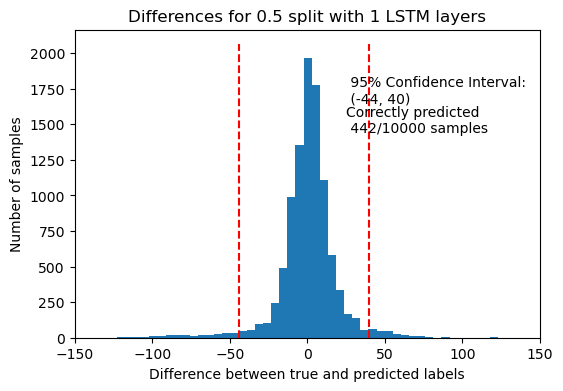

Number of correct predicted labels: 454 out of 15000 samples
Confidence interval: (-70, 42)


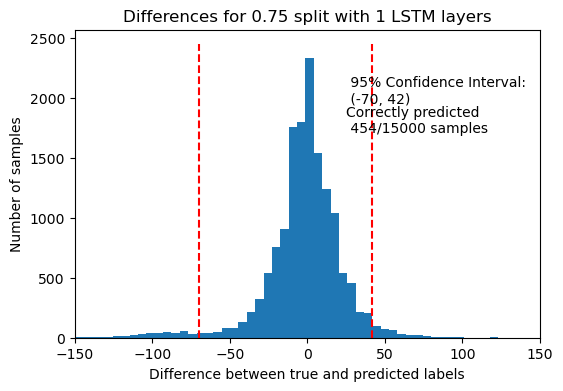

Number of correct predicted labels: 323 out of 18000 samples
Confidence interval: (-83, 58)


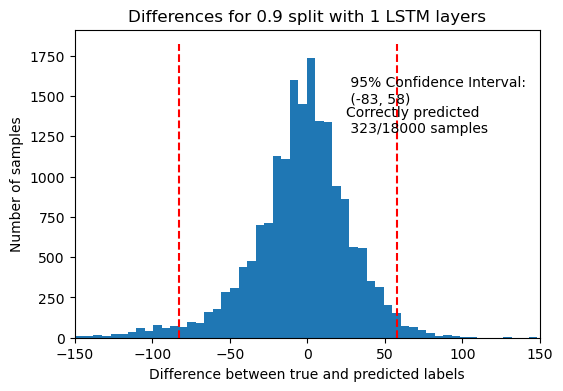

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def find_confidence_interval(data, confidence=0.95):
    """
    Calculate the confidence interval for a given dataset and confidence level.

    Parameters:
    data (np.array): The dataset as a NumPy array.
    confidence (float): The confidence level, default is 0.95 for a 95% confidence interval.

    Returns:
    tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the number of data points
    n = len(sorted_data)

    # Calculate indexes for the lower and upper bounds
    lower_index = int(n * ((1 - confidence) / 2))
    upper_index = int(n * (1 - (1 - confidence) / 2))

    # Extract values at these indexes
    lower_bound = sorted_data[lower_index]
    upper_bound = sorted_data[upper_index]

    return (lower_bound, upper_bound)


def plot_distribution(
    split,
    results,
    num_LSTM,
    num_bins=200,
):
    plt.figure(figsize=(6, 4))
    delta_labels = results[split]["predicted_labels"] - results[split]["true_labels"]
    plt.hist(
        delta_labels,
        bins=num_bins,
    )
    num_corret_predicted = np.where(delta_labels == 0)[0].shape[0]
    confidence_interval = find_confidence_interval(delta_labels)
    print(
        f"Number of correct predicted labels: {num_corret_predicted} out of {delta_labels.shape[0]} samples"
    )
    print(f"Confidence interval: {confidence_interval}")

    ymax = plt.ylim()[1]
    plt.vlines(confidence_interval[0], 0, ymax, colors="r", linestyles="dashed")
    plt.vlines(confidence_interval[1], 0, ymax, colors="r", linestyles="dashed")
    plt.text(
        25,
        ymax * 0.8,
        f" 95% Confidence Interval: \n {confidence_interval}",
    )
    plt.text(
        25,
        ymax * 0.7,
        f"Correctly predicted \n {num_corret_predicted}/{delta_labels.shape[0]} samples",
    )

    plt.xlabel("Difference between true and predicted labels")
    plt.ylabel("Number of samples")
    plt.xlim(-150, 150)
    plt.title(f"Differences for {split} split with {num_LSTM} LSTM layers")
    plt.savefig(f"+-hist_{split}_{num_LSTM}.png")
    plt.show()
    return num_corret_predicted, confidence_interval


for split in splits:
    plot_distribution(split, results_p1_2_v1_int, num_LSTM=1)

Number of correct predicted labels: 911 out of 10000 samples
Confidence interval: (-23, 39)


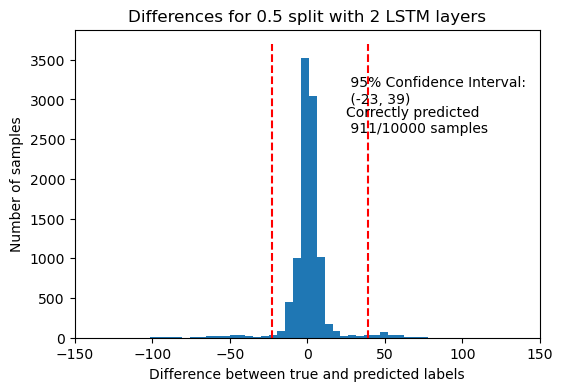

Number of correct predicted labels: 626 out of 15000 samples
Confidence interval: (-42, 35)


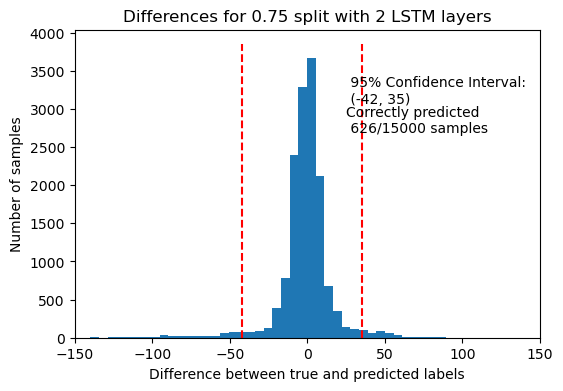

Number of correct predicted labels: 346 out of 18000 samples
Confidence interval: (-54, 54)


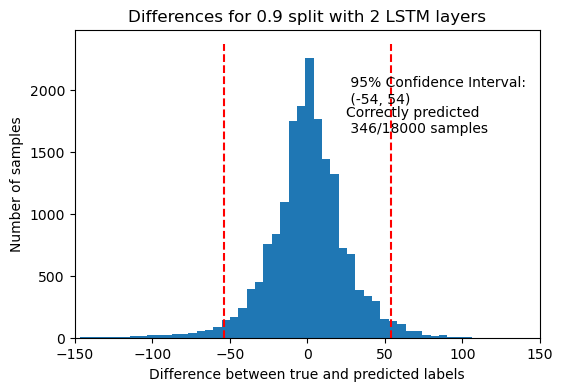

In [37]:
for split in splits:
    plot_distribution(split, results_p1_2_v2_int, num_LSTM=2, num_bins=200)

Number of correct predicted labels: 713 out of 10000 samples
Confidence interval: (-16, 15)


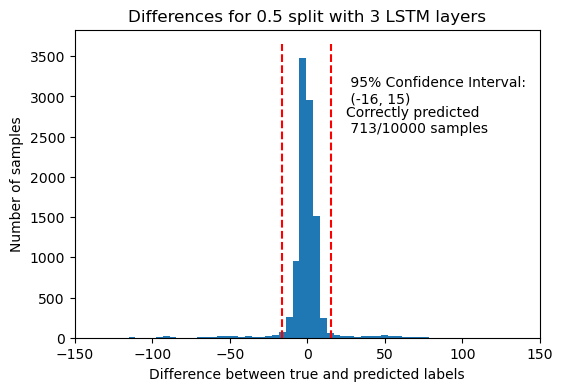

Number of correct predicted labels: 759 out of 15000 samples
Confidence interval: (-23, 32)


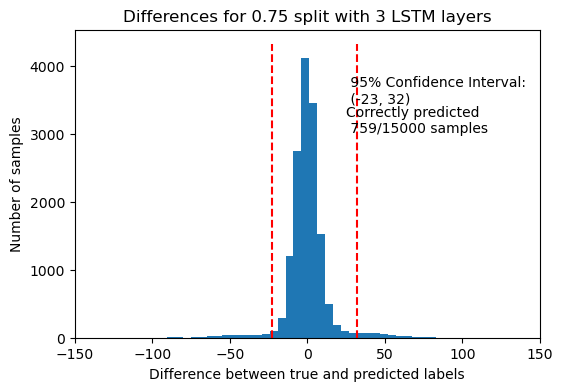

Number of correct predicted labels: 379 out of 18000 samples
Confidence interval: (-52, 42)


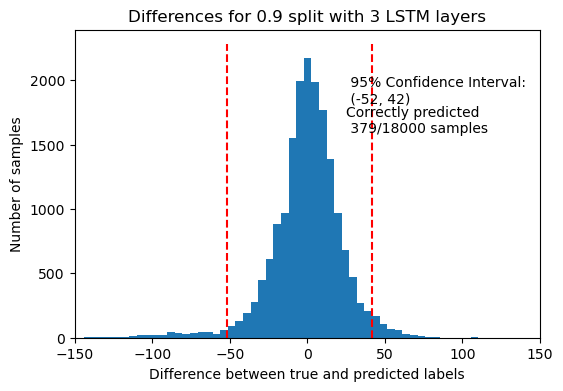

In [38]:
for split in splits:
    plot_distribution(split, results_p1_2_v3_int, num_LSTM=3, num_bins=200)

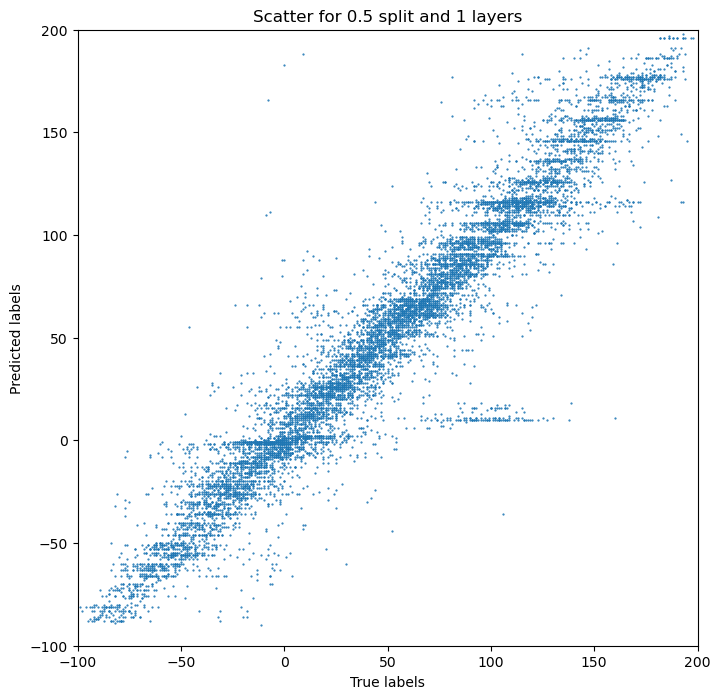

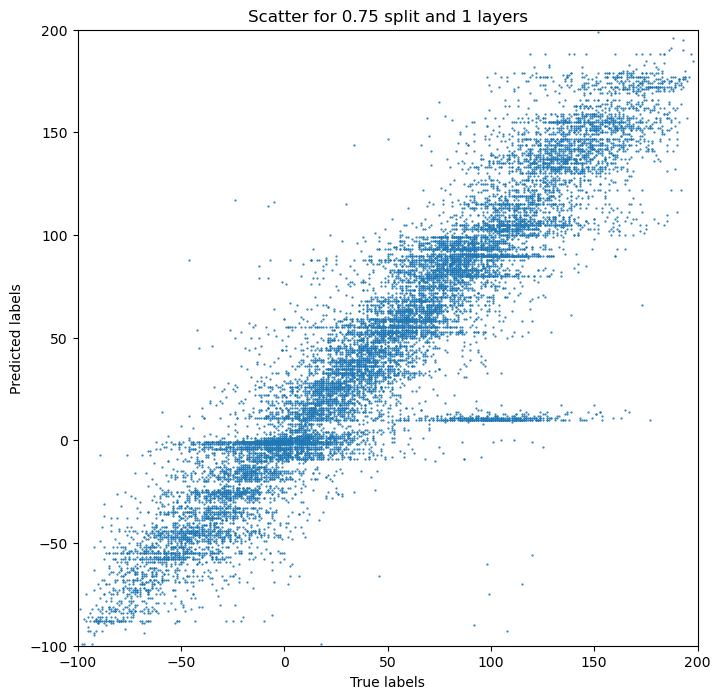

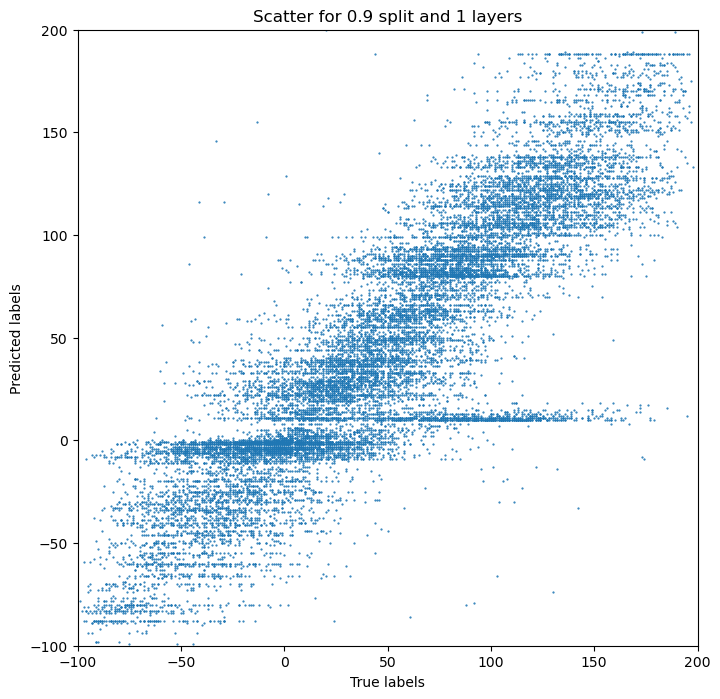

In [40]:
def plot_scatters(split, results, num_LMST):
    plt.figure(figsize=(8, 8))
    plt.scatter(
        results[split]["true_labels"],
        results[split]["predicted_labels"],
        s=0.3,
    )
    plt.ylabel("Predicted labels")
    plt.xlabel("True labels")
    plt.title(f"Scatter for {split} split and {num_LMST} layers")
    plt.ylim(-100, 200)
    plt.xlim(-100, 200)
    plt.savefig(f"+-scatter_{split}_{num_LMST}.png")
    plt.show()


for split in splits:
    plot_scatters(split, results_p1_2_v1, num_LMST=1)

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [9]:
# Your code


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)
Query #9840

X_text: "98*40" = y_text: "3920 "


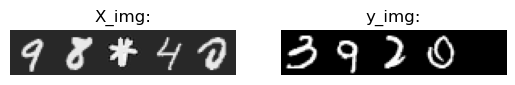

Query #7896

X_text: "78*96" = y_text: "7488 "


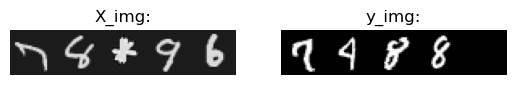

Query #4638

X_text: "46*38" = y_text: "1748 "


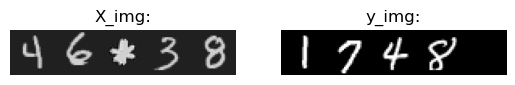

Query #7078

X_text: "70*78" = y_text: "5460 "


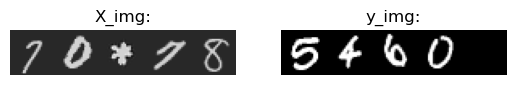

Query #7576

X_text: "75*76" = y_text: "5700 "


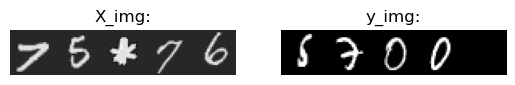

Query #5099

X_text: "50*99" = y_text: "4950 "


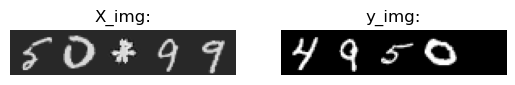

Query #7454

X_text: "74*54" = y_text: "3996 "


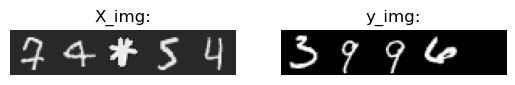

Query #3598

X_text: "35*98" = y_text: "3430 "


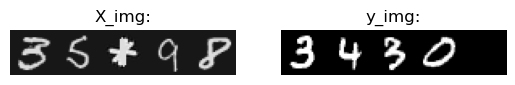

Query #2928

X_text: "29*28" = y_text: "812  "


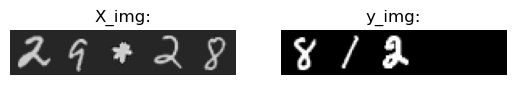

Query #9918

X_text: "99*18" = y_text: "1782 "


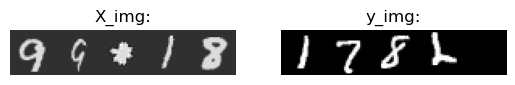

In [47]:
# Illustrate the generated query/answer pairs

unique_characters = "0123456789* "  # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99  # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = (
    max_int_length * 2 + 1
)  # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5  # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text2, X_img2, y_text2, y_img2 = create_data(highest_integer, operands=["*"])
print(X_text2.shape, X_img2.shape, y_text2.shape, y_img2.shape)


## Display the samples that were created
def display_sample(n):
    labels = ["X_img:", "y_img:"]
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1, 2, i + 1)
        # plt.set_figheight(15)
        plt.axis("off")
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap="gray")
    print("=" * 50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()


for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

### Image-to-Text Model

In [39]:
## Your code

X_text2_onehot = encode_labels(X_text2)
y_text2_onehot = encode_labels(y_text2)

# Modified training and evaluation for different splits
splits = [0.5, 0.75, 0.9]  # Train-test splits, the number is the ratio of test data
# the out put from model with two LSTM layers in encoder
results_p2_2_v1 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img2, y_text2_onehot, build_image_to_text_model()
    )
    results_p2_2_v1[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-03 14:32:36.056140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:32:36.057545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:32:36.059561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_27 (LSTM)              (None, 256)               1065984   
                                                                 
 repeat_vector_9 (RepeatVect  (None, 5, 256)           0         
 or)                                                             
                                                                 
 lstm_28 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_19 (TimeDi  (None, 5, 12)            3084      
 stributed)                                                      
                                                      

2023-12-03 14:32:36.270223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:32:36.271864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:32:36.273030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-12-03 14:32:36.890470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:32:36.892908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:32:36.894535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - ETA: 0s - loss: 1.7918 - accuracy: 0.3618

2023-12-03 14:32:44.190559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:32:44.192014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:32:44.193297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 9s 72ms/step - loss: 1.7918 - accuracy: 0.3618 - val_loss: 1.6459 - val_accuracy: 0.3991
Epoch 2/15
79/79 [==============================] - 5s 60ms/step - loss: 1.6166 - accuracy: 0.4058 - val_loss: 1.6270 - val_accuracy: 0.4024
Epoch 3/15
79/79 [==============================] - 5s 60ms/step - loss: 1.5694 - accuracy: 0.4184 - val_loss: 1.5410 - val_accuracy: 0.4259
Epoch 4/15
79/79 [==============================] - 5s 62ms/step - loss: 1.5113 - accuracy: 0.4402 - val_loss: 1.5110 - val_accuracy: 0.4328
Epoch 5/15
79/79 [==============================] - 5s 63ms/step - loss: 1.4642 - accuracy: 0.4548 - val_loss: 1.4966 - val_accuracy: 0.4409
Epoch 6/15
79/79 [==============================] - 5s 64ms/step - loss: 1.4069 - accuracy: 0.4750 - val_loss: 1.4891 - val_accuracy: 0.4432
Epoch 7/15
79/79 [==============================] - 5s 63ms/step - loss: 1.3547 - accuracy: 0.4938 - val_loss: 1.4485 - val_accuracy: 0.4575
Epoch 8/15
79/79 [======

2023-12-03 14:33:58.070806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:33:58.071863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:33:58.073251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 3s 12ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-03 14:34:00.805160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:34:00.806563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:34:00.807541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_29 (LSTM)              (None, 256)               1065984   
                                                                 
 repeat_vector_10 (RepeatVec  (None, 5, 256)           0         
 tor)                                                            
                                                                 
 lstm_30 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_21 (TimeDi  (None, 5, 12)            3084      
 stributed)                                                      
                                                     

2023-12-03 14:34:01.055102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:34:01.056662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:34:01.057829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-12-03 14:34:01.590372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:34:01.591884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:34:01.593123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - ETA: 0s - loss: 1.9137 - accuracy: 0.3322

2023-12-03 14:34:06.964805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:34:06.965760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:34:06.966955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 8s 112ms/step - loss: 1.9137 - accuracy: 0.3322 - val_loss: 1.7418 - val_accuracy: 0.3737
Epoch 2/15
40/40 [==============================] - 4s 90ms/step - loss: 1.6821 - accuracy: 0.3897 - val_loss: 1.6481 - val_accuracy: 0.3967
Epoch 3/15
40/40 [==============================] - 4s 92ms/step - loss: 1.6272 - accuracy: 0.3981 - val_loss: 1.6099 - val_accuracy: 0.4041
Epoch 4/15
40/40 [==============================] - 5s 115ms/step - loss: 1.5778 - accuracy: 0.4166 - val_loss: 1.5890 - val_accuracy: 0.4149
Epoch 5/15
40/40 [==============================] - 4s 95ms/step - loss: 1.5493 - accuracy: 0.4250 - val_loss: 1.6277 - val_accuracy: 0.4073
Epoch 6/15
40/40 [==============================] - 4s 91ms/step - loss: 1.5366 - accuracy: 0.4300 - val_loss: 1.6077 - val_accuracy: 0.4156
Epoch 7/15
40/40 [==============================] - 4s 89ms/step - loss: 1.4857 - accuracy: 0.4498 - val_loss: 1.5704 - val_accuracy: 0.4129
Epoch 8/15
40/40 [====

2023-12-03 14:35:02.650421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:02.651994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:02.653470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 3s 10ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-03 14:35:06.115538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:06.116937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:06.118962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_31 (LSTM)              (None, 256)               1065984   
                                                                 
 repeat_vector_11 (RepeatVec  (None, 5, 256)           0         
 tor)                                                            
                                                                 
 lstm_32 (LSTM)              (None, 5, 256)            525312    
                                                                 
 time_distributed_23 (TimeDi  (None, 5, 12)            3084      
 stributed)                                                      
                                                     

2023-12-03 14:35:06.366226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:06.367585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:06.369023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-12-03 14:35:06.891516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:06.893259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:06.894575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/16 [===========================>..] - ETA: 0s - loss: 2.1228 - accuracy: 0.2727

2023-12-03 14:35:11.212772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:11.214634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:11.215964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 7s 222ms/step - loss: 2.1159 - accuracy: 0.2738 - val_loss: 1.8896 - val_accuracy: 0.3160
Epoch 2/15
16/16 [==============================] - 3s 167ms/step - loss: 1.7944 - accuracy: 0.3508 - val_loss: 1.7214 - val_accuracy: 0.3794
Epoch 3/15
16/16 [==============================] - 3s 166ms/step - loss: 1.7097 - accuracy: 0.3796 - val_loss: 1.6846 - val_accuracy: 0.3880
Epoch 4/15
16/16 [==============================] - 3s 170ms/step - loss: 1.6610 - accuracy: 0.3944 - val_loss: 1.6822 - val_accuracy: 0.3885
Epoch 5/15
16/16 [==============================] - 3s 169ms/step - loss: 1.6175 - accuracy: 0.4004 - val_loss: 1.6438 - val_accuracy: 0.3990
Epoch 6/15
16/16 [==============================] - 3s 203ms/step - loss: 1.5918 - accuracy: 0.4158 - val_loss: 1.6314 - val_accuracy: 0.4043
Epoch 7/15
16/16 [==============================] - 3s 182ms/step - loss: 1.5428 - accuracy: 0.4336 - val_loss: 1.6302 - val_accuracy: 0.4054
Epoch 8/15
16/16 

2023-12-03 14:35:56.238698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-03 14:35:56.241056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-03 14:35:56.242787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

282/282 [==============================] - 4s 10ms/step


In [41]:
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p2_2_v1[split]['accuracy']}")
    # print(f"Model with 2 LSTM layers: {results_p1_2_v2[split]['accuracy']}")
    # print(f"Model with 3 LSTM layers: {results_p1_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.4671599864959717

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.4309599995613098

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.3918222188949585



In [42]:
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p1_2_v1[split]['accuracy']}")
    # print(f"Model with 2 LSTM layers: {results_p1_2_v2[split]['accuracy']}")
    # print(f"Model with 3 LSTM layers: {results_p1_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.4652000069618225

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.42260000109672546

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.3745926022529602

